# Classification Predict - Climate Change

### Table of contents

### Problem identification

In [ ]:
# background and problem statement 

### What data do we have?

In [ ]:
# description of data

### Start experiment

##### Install necessary packages

In [ ]:
# Install necessary packages
# !pip install comet_ml

In [ ]:
!pip install -U spacy

In [ ]:
!pip install seaborn

In [ ]:
!pip install wordcloud

In [1]:
!pip install emoji

In [3]:
!pip install pyspellchecker

In [50]:
!pip install ftfy

In [55]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Amogelang
[nltk_data]     Mpyatona\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# from comet_ml import Experiment

In [ ]:
# Setting the API key (saved as environment variable)
# experiment = Experiment(api_key="upOwchWrd7H1e6VEnWKW7PSvz", project_name="classification-predict", workspace="team-rm1")

### Import libraries

In [102]:
import re
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score,classification_report

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.probability import FreqDist


import emoji
#cleaning unicode
from ftfy import fix_text 

from ftfy import fix_text

from spellchecker import SpellChecker 

from nltk.stem.snowball import SnowballStemmer

from sklearn.pipeline import Pipeline

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import itertools

import pickle

### Import data

In [38]:
df_test = pd.read_csv('https://raw.githubusercontent.com/Amogelang20/RM1_classification_predict/dev/test.csv')
df_train = pd.read_csv('https://raw.githubusercontent.com/Amogelang20/RM1_classification_predict/dev/train.csv')

In [39]:
df_train.set_index('tweetid',inplace = True)
df_train.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [40]:
df_test.set_index('tweetid',inplace = True)
df_test.head()

,message
tweetid,
169760,Europe will now be looking to China to make su...
35326,Combine this with the polling of staffers re c...
224985,"The scary, unimpeachable evidence that climate..."
476263,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...


### Exploratory data analysis

Let us first get quick overview of the dataset we will be working with throughout the notebook. Below is a list of all columns with their data types and the number of non-null values in each column.

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15819 entries, 625221 to 806319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
dtypes: int64(1), object(1)
memory usage: 309.0+ KB


There are only two columns present in the training dataset; the label variable we want to classify to (`'sentiment'`), and the feature we will use to make this classification (`'message'`). We initially had a third column (`'tweetid'`) but set this column to be the index of the dataset.  The dataset contains no null entries, and the data types for (`'sentiment'`) and (`'message'`) are integer and object respectively. 

Next we will have a look at the different labels we will be classifying to.

In [9]:
df_train['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

The label has four different classes, each described further in the following table:  

|Class|Tag|Description|  
|:---:|:---:|:---|  
|**-1**|**Anti**|The tweet does not believe in man-made climate change|  
|**0**|**Neutral**|The tweet neither supports nor refuses the belief of man-made climate change|   
|**1**|**Pro**|The tweet supports the belief of man-made climate change|   
|**2**|**News**|The tweet links to factual news about climate change|  

Let us have a look at the data associated with each class.

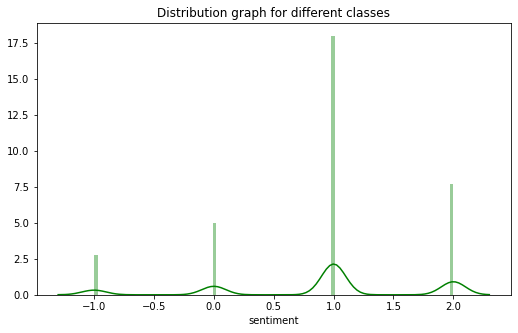

In [105]:
plot1 = plt.figure(figsize=(8.5,5))
sns.distplot(df_train['sentiment'],
             color='g',kde_kws={'bw':0.1}, bins=100, hist_kws={'alpha': 0.4})
plt.title('Distribution graph for different classes');

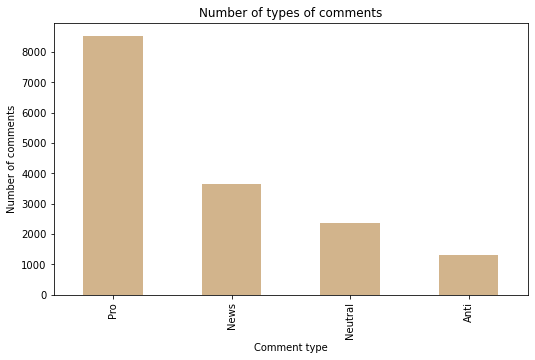

In [115]:
plot2 = df_train['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts().plot(kind='bar',figsize=(8.5,5), color='tan');
plt.title('Number of types of comments');
plt.xlabel('Comment type');
plt.ylabel('Number of comments');

Examining the plot reveals that the majority of the tweets are classified as Pro, i.e. supports the belief of man-made climate change. Since the classes are so unbalanced we expect the classification algorithm to perform better when classifying larger classes ( _Pro_ ) than the smaller classes ( _News, Neutral, Anti_ ).  
We have then created a funtion to deal with the uneven distribution of class labels. The function will modify the number of observations for a class(es) we need to resample. 

In [12]:
#Function takes in a dataframe, a class to be resampled, and a class whose observations are to be matched with.
#df is the dataframe
#class1 is the class that is to be resampled
#class2 is the class whose length is used to resample class1
def resampling(df, class1, class2):
    df_class1= df[df.sentiment==class1]
    df_class2 = df[df.sentiment==class2]
    df_new= df[df.sentiment!=class1]
    resampled = resample(df_class1, replace=False, n_samples=len(df_class2), random_state=27)
    df_resampled = pd.concat([resampled, df_new])    
    return df_resampled

Let us have a look at the most common words associated with each class.

In [25]:
df_Pro = df_train[df_train.sentiment==1]
df_News=df_train[df_train.sentiment==2]
df_Neutral=df_train[df_train.sentiment==0]
df_Anti=df_train[df_train.sentiment==-1]

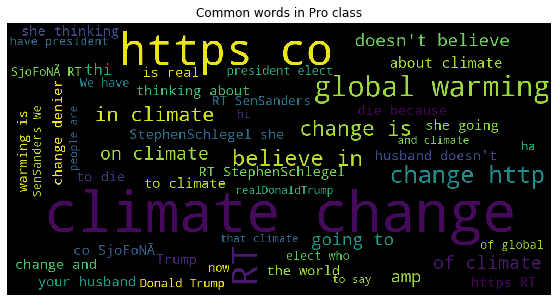

In [37]:
k= (' '.join(df_Pro['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(k)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in Pro class');

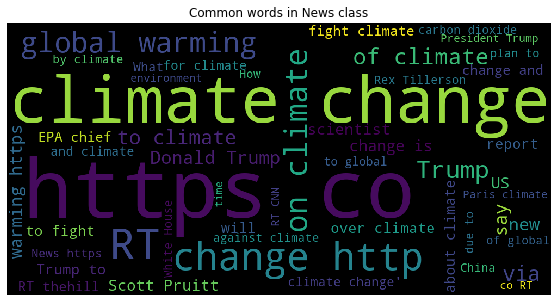

In [14]:
l= (' '.join(df_News['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(l)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in News class');

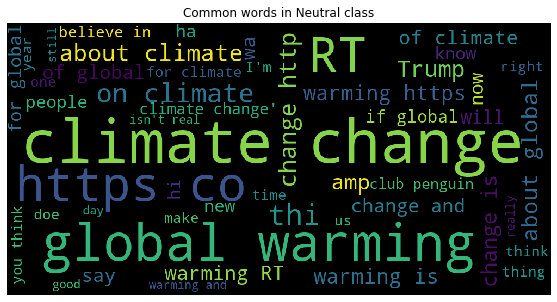

In [15]:
m= (' '.join(df_Neutral['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(m)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in Neutral class');

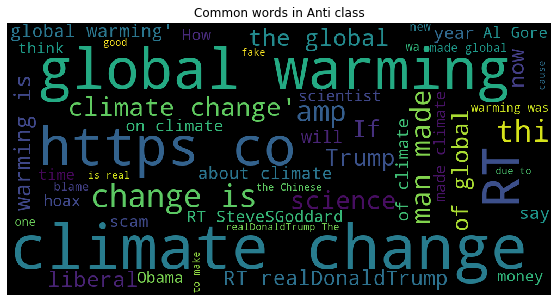

In [16]:
n= (' '.join(df_Anti['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(n)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in Anti class');

### Preprocessing

In [ ]:
#### CLEANING ####
# handle some of the unnecessary punctuation 
# upper/lower case
# change the slang words into something more meaningful to machine learning
# handle missing data and empty strings
# ect.


The `message` column is in its raw form and needs cleaning for the model to be able to process, make analysis and provide predictions for sentiments. Next we will be cleaning the data.

**Missing values**

In [13]:
print(df_train.isnull().sum())

sentiment    0
message      0
dtype: int64


There are no missing entries present in the training set. But since an empty string for tweets can also be considered as a missing entry, we need to check for empty strings in the `message` column as well.

In [42]:
#checking for empty strings
blanks = [i for i,lb,tweet in df_train.itertuples() if type(tweet) == str if tweet.isspace()]
blanks

[]

The list is empty, indicating that there are no empty strings.

**Duplicates**

In [43]:
#checking for duplicates in tweets
df_train[df_train.duplicated(subset='message') == True].count()/len(df_train)*100

sentiment    10.051204
message      10.051204
dtype: float64

10% of the tweets seem to be duplicated tweets but with different ID's. Since we don't have a significantly large amount of data we will keep these duplicates and check the impact of having them or not having them, when we fit the models.

##### Cleaning words in text column

First we'll extract some extra features that can possibly improve the model's accuracy.

In [44]:
# Extract all unique news related handles into a list
n_temp = [re.findall(r'@[\w]+',df_train['message'].iloc[i]) for i,x in enumerate(df_train['sentiment']) if x==2]
news = [x for x in n_temp if x!=[]]
news = list(set(itertools.chain.from_iterable(news)))

In [45]:
#extract all hashtags to create separate words out of them
hashtags = pd.DataFrame([', '.join(re.findall(r'#[\w]+',t)) for t in df_train['message']],columns=['hashtags'])

In [46]:
# Function to extract sentiment
def sentiment_score(text):
    '''docstring'''
    
    sid = SentimentIntensityAnalyzer()
    s = sid.polarity_scores(text)['compound']
    if s<-0.05:
        sentiment='negative'
    elif s>0.05:
        sentiment='positive'
    else:
        sentiment='neutral'
    
    return sentiment

Start cleaning.

The `message` column contains some contracted words such as *can't* and *don't*. As part of the cleaning process these words will be replaced with their expanded words that don't contain any ommission. A dictionary `contactions` is created with all the contractions and their corresponding full words.

In [47]:
# Dictionary of contracted words
contractions = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"wasn't": "was not",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we'll":"we will",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
}

With tweets data a lot of shortened words like *abt* are used instead of the full words *about*. This can make it difficult for the model to process these words. We will replace the shortened words with their corresponding full word. A dictionary of all the shortened words with their corresponding full words is given.

In [52]:
#replace shortened words with full words
short = {' BD ': 'Big Deal',
 ' abt ':'about',
 ' ab ': 'about',
 ' fav ': 'favourite',
 ' fab ': 'fabulous',
 ' smh ': 'shaking my head',
 ' u ': 'you',
 ' c ': 'see',
 ' anon ': 'anonymous',
 ' ac ': 'aircon',
 ' a/c ': 'aircon',
 ' yo ':'year old',
 ' n ':'and',
 ' nd ':'and',
 ' 2 ': 'to',
 ' w ': 'with',
 ' w/o ': 'without',
 ' r ': 'are',
 ' rip ':'rest in peace',
 ' 4 ' : 'for',
 ' f4f ' : 'follow for follow',
' BF ': 'Boyfriend',
' BRB ': 'Be Right Back',
' BTW ': 'By The Way',
' GF ': 'Girlfriend',
' HBD ': 'Happy Birthday',
' JK ': 'Just Kidding',
' K ':'Okay',
' LMK ': 'Let Me Know',
' LOL ': 'Laugh Out Loud',
' HA ':'laugh',
' MYOB ': 'Mind Your Own Business',
' NBD ': 'No Big Deal',
' NVM ': 'Nevermind',
' Obv ':' Obviously',
' Obvi ':' Obviously',
' OMG ': 'Oh My God',
' Pls ': 'Please',' Plz ': 'Please',
' Q ': 'Question', ' QQ ': 'Quick Question',
' RLY ': 'Really',
' SRLSY ': 'Seriously',
' TMI ': 'Too Much Information',
' TY ': 'Thank You,',
' TYVM ': 'Thank You Very Much',
' YW ': 'You are Welcome',
' FOMO ': 'Fear Of Missing Out',
' FTFY ': 'Fixed This For You',
' FTW ': 'For The Win',
' FYA ': 'For Your Amusement',
' FYE ': 'For Your Entertainment',
' GTI ': 'Going Through It',
' HTH ': 'Here to Help',
' IRL ': 'In Real Life',
' ICYMI ': 'In Case You Missed It',
' ICYWW ': 'In Case You Were Wondering',
' NBC ': 'Nobody Cares Though',
' NTW ': 'Not To Worry',
' OTD ': 'Of The Day',
' OOTD ': 'Outfit Of The Day',
' QOTD ': 'Quote of the Day',
' FOTD ': 'Find Of the Day',
' POIDH ': 'Pictures Or It Did ntt Happen',
' YOLO ': 'You Only Live Once',
' AFAIK ': 'As Far As I Know',
' DGYF ': 'Dang Girl You Fine',
' FWIW ': 'For What It is Worth',
' IDC ': 'I Do not Care',
' IDK ': 'I Do not Know',
' IIRC ': 'If I Remember Correctly',
' IMHO ': 'In My Honest Opinion',
' IMO ': 'In My Opinion',
' Jelly ': 'Jealous',
' Jellz ': 'Jealous',
' JSYK ': 'Just So You Know',
' LMAO ': 'Laughing My Ass Off',
' LMFAO ': 'Laughing My Fucking Ass Off',
' NTS ': 'Note to Self',
' ROFL ': 'Rolling On the Floor Laughing',
' ROFLMAO ': 'Rolling On the Floor Laughing My Ass Off',
' SMH ': 'Shaking My Head',
' TBH ': 'To Be Honest',
' TL;DR ':  'Too Long; Did not Read',
' TLDR ':  'Too Long; Did not Read',
' YGTR ': 'You Got That Right',
' AYKMWTS ': 'Are You Kidding Me With This Shit',
' BAMF ': 'Bad Ass Mother Fucker',
' FFS ': 'For Fuck Sake',
' FML ': 'Fuck My Life',
' HYFR ': 'Hell Yeah Fucking Right',
' IDGAF ': 'I Do not Give A Fuck',
' NFW ': 'No Fucking Way',
' PITA ': 'Pain In The Ass',
' POS ': 'Piece of Shit',
' SOL ': 'Shit Outta Luck',
' STFU ': 'Shut the Fuck Up',
' TF ': 'The Fuck',
' WTF ': 'What The Fuck',
' BFN ': 'Bye For Now',
' CU ': 'See You',
' IC ': 'I see',
' CYL ': 'See You Later',
' GTG ': 'Got to Go',
' OMW ': 'On My Way',
' RN ': 'Right Now',
' TTYL ': 'Talk To You Later',
' TYT ': 'Take Your time',
' CC ': 'Carbon Copy',
' CX ': 'Correction',
' DM ': 'Direct Message',
' FB ': 'Facebook',
' FBF ': 'Flash-Back Friday',
' FF ': 'Follow Friday',
' HT ': 'Tipping my hat',
' H/T ': 'Tipping my hat',
' IG ': 'Instagram',
' Insta ': 'Instagram',
' MT ':' Modified Tweet',
' OH ': 'Overheard',
' PRT ': 'Partial Retweet',
' RT ': 'Retweet ',
'rt ' : 'retweet ',
' SO ':'Shout Out',
' S/O ': 'Shout Out',
' TBT ': 'Throw-Back Thursday',
' AWOL ': 'Away While Online',
' BFF ': 'Best Friend Forever',
' NSFW ': 'Not Safe For Work',
' OG ': 'Original Gangster',
' PSA ': 'Public Service Announcement',
' PDA ': 'Public Display of Affection',
' int ' : 'international',
' m ': 'am',
' smog ':'smoke and fog',
' clgd ':'climate change law governance day',
' clpd ':'climate launch pad',
' lfg ': 'Liquefied natural gas',
'gov ' : 'government',
' govt ' : 'government',
' agr ' : 'agreement',
' lega ' : 'legacy',
' cli ' : 'cliche',
' usfa ' : 'united states Fire Administration',
' wgbc ' : 'world green building council',
' ooc ' : 'out of character',
' agw ':'Anthropogenic global warming',
' 1o5c ' : '1.5 degree celsius',
' fftf17 ' :'festival of the future',
' brrrr ' : ' shivering ',
' merc ' : ' mercedes benz ',
' ngss ' : 'Next Generation Science Standards',
' dev ' : 'development',
' dist ' : 'distance',
' co2 ': 'carbon dioxide',
' conf ' : 'conference',
    ' pro ' : 'professional',
    ' utd ' : 'united',
' viz ' : 'visualization',
' environ ': 'environment',
' chem ' : 'chemical',
' ny ' : 'new york'      }
short = dict((key.lower(), value.lower()) for key,value in short.items())

Tweets data can have alot of noise in it from the type of language, style and grammer used, that the computer may find hard to process. These issues have to be dealt with in order for the model to be abe to process the text data and make predictions. A function(`cleanup(df,column_name) `) is created that handles all these issues:

We will work with lower cased data to remove noise from capitalised words as the computer may see uppercased words as different from lower cased words.

Tweets data can also include bad unicode where a person wants so say `José Florés` or use a `(—)` but it ends up being `JosÃ© Florés` or `â€”` instead. These issues can make it hard for the model to process the data. There is a package in python that takes care of these issues for us. The ftfy(fixed this for you package) takes all the bad unicode and outputs the good unicode

The `message` column contains some contracted words such as *can't* and *don't*. As part of the cleaning process these words will be replaced with their expanded words that don't contain any ommission. 

The `message` column may also contain emojis 👨🏽‍💻 which alone are just symbols and don't have a word association for them. So the emojis will be replaced with the word that describes them.

With tweets data a lot of shortened words like *abt* are used instead of the full words *about*. This can make it difficult for the model to process these words. We will replace the shortened words with their corresponding full word.

In [53]:
def cleanup(df,column_name):
    """this function takes in a dataframe and the name of the column with text data and returns a modified dataframe.
    The text column gets modified by being; lower cased,removing urls,removing bad unicode,replacing contractions,
    replacing emojis with words and replacing shortened words"""
    
    df[column_name] = df[column_name].str.lower() #lower case all words to remove noise from Capital words
    df[column_name] = df[column_name].apply(lambda x: fix_text(x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'https\S+','url',x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'www\S+', 'url',x))
    for word in contractions.keys():
        df[column_name] = df[column_name].apply(lambda x: re.sub(word,contractions[word],x))
    for word in short.keys():
        df[column_name] = df[column_name].apply(lambda x: re.sub(word,short[word],x))
    df[column_name] = df[column_name].apply(lambda x: emoji.demojize(x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'retweet',' \g<0> ',x)) #separate 'retweet' from the handle
    df[column_name] =  df['message'].apply(lambda x: re.sub(r'[^@\w\s]','',x)) #remove punctuation
    return df


In [ ]:
df_train = cleanup(df_train,'message')

In [48]:
#replace contracted words with full word
df_train['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) for raw in df_train['message']]
df_train.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: it is 2016, and a racist,..."


In [49]:
#lower case all words to remove noise from Capital words. Capital words may be seen as different from lower case words
df_train['message'] = df_train['message'].str.lower()
df_train.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,rt @rawstory: researchers say we have three ye...
573736,1,#todayinmaker# wired : 2016 was a pivotal year...
466954,1,"rt @soynoviodetodas: it is 2016, and a racist,..."


Tweets data can also include bad unicode where a person wants so say `José Florés` or use a `(—)` but it ends up being `JosÃ© Florés` or `â€”` instead. These issues can make it hard for the model to process the data. There is a package in python that takes care of these issues for us. The ftfy(fixed this for you package) takes all the bad unicode and outputs the good unicode

In [50]:
df_train['message'] = df_train['message'].apply(lambda x: fix_text(x))
df_train.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,rt @rawstory: researchers say we have three ye...
573736,1,#todayinmaker# wired : 2016 was a pivotal year...
466954,1,"rt @soynoviodetodas: it is 2016, and a racist,..."


In [51]:
#removing urls
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'https\S+','url',x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'www\S+', 'url',x))
df_train.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,rt @rawstory: researchers say we have three ye...
573736,1,#todayinmaker# wired : 2016 was a pivotal year...
466954,1,"rt @soynoviodetodas: it is 2016, and a racist,..."


The `message` column may also contain emojis 👨🏽‍💻 which alone are just symbols and don't have a word association for them. So the emojis will be replaced with the word that describes them.

In [52]:
#replace emojis with their word meaning
df_train['message'] = df_train['message'].apply(lambda x: emoji.demojize(x))
df_train.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,rt @rawstory: researchers say we have three ye...
573736,1,#todayinmaker# wired : 2016 was a pivotal year...
466954,1,"rt @soynoviodetodas: it is 2016, and a racist,..."


With tweets data a lot of shortened words like *abt* are used instead of the full words *about*. This can make it difficult for the model to process these words. We will replace the shortened words with their corresponding full word. A dictionary of all the shortened words with their corresponding full words is given.

In [53]:
#replace shortened words with full words
short = {' BD ': ' Big Deal ',
 ' abt ':' about ',
 ' ab ': ' about ',
 ' fav ': ' favourite ',
 ' fab ': ' fabulous ',
 ' smh ': ' shaking my head ',
 ' u ': ' you ',
 ' c ': ' see ',
 ' anon ': ' anonymous ',
 ' ac ': ' aircon ',
 ' a/c ': ' aircon ',
 ' yo ':' year old ',
 ' n ':' and ',
 ' nd ':' and ',
 ' 2 ': ' to ',
 ' w ': ' with ',
 ' w/o ': ' without ',
 ' r ': ' are ',
 ' rip ':' rest in peace ',
 ' 4 ' : ' for ',
' BF ': ' Boyfriend ',
' BRB ': ' Be Right Back ',
' BTW ': ' By The Way ',
' GF ': ' Girlfriend ',
' HBD ': ' Happy Birthday ',
' JK ': ' Just Kidding ',
' K ':' Okay ',
' LMK ': ' Let Me Know ',
' LOL ': ' Laugh Out Loud ',
' HA ':' laugh ',
' MYOB ': ' Mind Your Own Business ',
' NBD ': ' No Big Deal ',
' NVM ': ' Nevermind ',
' Obv ':' Obviously ',
' Obvi ':' Obviously ',
' OMG ': ' Oh My God ',
' Pls ': ' Please ',
' Plz ': ' Please ',
' Q ': ' Question ', 
' QQ ': ' Quick Question ',
' RLY ': ' Really ',
' SRLSY ': ' Seriously ',
' TMI ': ' Too Much Information ',
' TY ': ' Thank You, ',
' TYVM ': ' Thank You Very Much ',
' YW ': ' You are Welcome ',
' FOMO ': ' Fear Of Missing Out ',
' FTFY ': ' Fixed This For You ',
' FTW ': ' For The Win ',
' FYA ': ' For Your Amusement ',
' FYE ': ' For Your Entertainment ',
' GTI ': ' Going Through It ',
' HTH ': ' Here to Help ',
' IRL ': ' In Real Life ',
' ICYMI ': ' In Case You Missed It ',
' ICYWW ': ' In Case You Were Wondering ',
' NBC ': ' Nobody Cares Though ',
' NTW ': ' Not To Worry ',
' OTD ': ' Of The Day ',
' OOTD ': ' Outfit Of The Day ',
' QOTD ': ' Quote of the Day ',
' FOTD ': ' Find Of the Day ',
' POIDH ': ' Pictures Or It Did ntt Happen ',
' YOLO ': ' You Only Live Once ',
' AFAIK ': ' As Far As I Know ',
' DGYF ': ' Dang Girl You Fine ',
' FWIW ': ' For What It is Worth ',
' IDC ': ' I Do not Care ',
' IDK ': ' I Do not Know ',
' IIRC ': ' If I Remember Correctly ',
' IMHO ': ' In My Honest Opinion ',
' IMO ': ' In My Opinion ',
' Jelly ': ' Jealous ',
' Jellz ': ' Jealous ',
' JSYK ': ' Just So You Know ',
' LMAO ': ' Laughing My Ass Off ',
' LMFAO ': ' Laughing My Fucking Ass Off ',
' NTS ': ' Note to Self ',
' ROFL ': ' Rolling On the Floor Laughing ',
' ROFLMAO ': ' Rolling On the Floor Laughing My Ass Off ',
' SMH ': ' Shaking My Head ',
' TBH ': ' To Be Honest ',
' TL;DR ':  ' Too Long; Did not Read ',
' TLDR ':  ' Too Long; Did not Read ',
' YGTR ': ' You Got That Right ',
' AYKMWTS ': ' Are You Kidding Me With This Shit ',
' BAMF ': ' Bad Ass Mother Fucker ',
' FFS ': ' For Fuck Sake ',
' FML ': ' Fuck My Life ',
' HYFR ': ' Hell Yeah Fucking Right ',
' IDGAF ': ' I Do not Give A Fuck ',
' NFW ': ' No Fucking Way ',
' PITA ': ' Pain In The Ass ',
' POS ': ' Piece of Shit ',
' SOL ': ' Shit Outta Luck ',
' STFU ': ' Shut the Fuck Up ',
' TF ': ' The Fuck ',
' WTF ': ' What The Fuck ',
' BFN ': ' Bye For Now ',
' CU ': ' See You ',
' IC ': ' I see ',
' CYL ': ' See You Later ',
' GTG ': ' Got to Go ',
' OMW ': ' On My Way ',
' RN ': ' Right Now ',
' TTYL ': ' Talk To You Later ',
' TYT ': ' Take Your time ',
' CC ': ' Carbon Copy ',
' CX ': ' Correction ',
' DM ': ' Direct Message ',
' FB ': ' Facebook ',
' FBF ': ' Flash-Back Friday ',
' FF ': ' Follow Friday ',
' HT ': ' Tipping my hat ',
' H/T ': ' Tipping my hat ',
' IG ': ' Instagram ',
' Insta ': ' Instagram ',
' MT ':' Modified Tweet ',
' OH ': ' Overheard ',
' PRT ': ' Partial Retweet ',
' RT ': ' Retweet ',
'rt ' : ' retweet ',
' SO ':' Shout Out ',
' S/O ': ' Shout Out ',
' TBT ': ' Throw-Back Thursday ',
' AWOL ': ' Away While Online ',
' BFF ': ' Best Friend Forever ',
' NSFW ': ' Not Safe For Work ',
' OG ': ' Original Gangster ',
' PSA ': ' Public Service Announcement ',
' PDA ': ' Public Display of Affection '}

short = dict((key.lower(), value.lower()) for key,value in short.items())

In [54]:
#replacing shortened words with full words
for word in short.keys():
    df_train['message'] = df_train['message'].apply(lambda x: re.sub(word,short[word],x))
df_train.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,retweet @rawstory: researchers say we have th...
573736,1,#todayinmaker# wired : 2016 was a pivotal year...
466954,1,"retweet @soynoviodetodas: it is 2016, and a r..."


In [55]:
#remove twitter non news related handles and @ symbol
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'@','', ' '.join([y for y in x.split() if y not in [z for z in re.findall(r'@[\w]*',x) if z not in news]])))
df_train.head()


,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,retweet rawstory: researchers say we have thre...
573736,1,#todayinmaker# wired : 2016 was a pivotal year...
466954,1,"retweet soynoviodetodas: it is 2016, and a rac..."


In [56]:
#remove punctuation (except ! for sentiment analysis)
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r"[^A-Za-z! ]*",'',x))
df_train.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,retweet rawstory researchers say we have three...
573736,1,todayinmaker wired was a pivotal year in the...
466954,1,retweet soynoviodetodas it is and a racist se...


In [57]:
#remove vowels repeated at least 3 times ex. Coooool > Cool
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'([aeiou])\1+', r'\1\1', x))
df_train.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,retweet rawstory researchers say we have three...
573736,1,todayinmaker wired was a pivotal year in the...
466954,1,retweet soynoviodetodas it is and a racist se...


In [58]:
#replace sequence of 'h' and 'a', as well as 'lol' with 'laugh'
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'ha([ha])*', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'lol([ol])*', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'lo([o])*l', r'laugh', x))
df_train.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,retweet rawstory researchers say we laughve th...
573736,1,todayinmaker wired was a pivotal year in the...
466954,1,retweet soynoviodetodas it is and a racist se...


In [59]:
#add sentiment
df_train['message'] = df_train['message'].apply(lambda x: x + ' ' + sentiment_score(x))  
df_train.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,retweet rawstory researchers say we laughve th...
573736,1,todayinmaker wired was a pivotal year in the...
466954,1,retweet soynoviodetodas it is and a racist se...


Tweets data can have alot of noise in it from the type of language, style and grammer used, that the computer may find hard to process. These issues have to be dealt with in order for the model to be abe to process the text data and make predictions. A function(`cleanup(df,column_name) `) is created that handles all these issues:

We will work with lower cased data to remove noise from capitalised words as the computer may see uppercased words as different from lower cased words.

Tweets data can also include bad unicode where a person wants so say `José Florés` or use a `(—)` but it ends up being `JosÃ© Florés` or `â€”` instead. These issues can make it hard for the model to process the data. There is a package in python that takes care of these issues for us. The ftfy(fixed this for you package) takes all the bad unicode and outputs the good unicode

The `message` column contains some contracted words such as *can't* and *don't*. As part of the cleaning process these words will be replaced with their expanded words that don't contain any ommission. 

The `message` column may also contain emojis 👨🏽‍💻 which alone are just symbols and don't have a word association for them. So the emojis will be replaced with the word that describes them.

With tweets data a lot of shortened words like *abt* are used instead of the full words *about*. This can make it difficult for the model to process these words. We will replace the shortened words with their corresponding full word.

In [60]:
def cleanup(raw):
    """this function takes in text data  as a string and returns a modified string.
    The text gets modified by being; lower cased,removing urls,removing bad unicode,replacing contractions,
    replacing emojis with words and replacing shortened words"""
    
    #convert to lowercase
    raw = raw.lower()
    
    #fix strange characters
    raw = fix_text(raw)
    
    #removing urls
    raw = re.sub(r'https\S+','url',raw)
    raw = re.sub(r'www\S+', 'url',raw)
    
    #replace emojis with their word meaning
    raw = emoji.demojize(raw)

    #remove twitter non news related handles and @ symbol
    raw = ' '.join([y for y in raw.split() if y not in [x for x in re.findall(r'@[\w]*',raw) if x not in news]])
    
    #remove punctuation (except ! for sentiment analysis)
    raw = re.sub(r"[^A-Za-z!' ]*",'',raw)
    
    #remove vowels repeated at least 3 times ex. Coooool > Cool
    raw = re.sub(r'([aeiou])\1+', r'\1\1', raw)
    
    #replace sequence of 'h' and 'a', as well as 'lol' with 'laugh'
    raw = re.sub(r'ha([ha])*', r'laugh', raw)
    raw = re.sub(r"lol([ol])*", r'laugh', raw)
    raw = re.sub(r"lo([o])*l", r'laugh', raw)
    
    #add sentiment
    raw = raw + ' ' + sentiment_score(raw)
    
    return raw


In [61]:
#replace contracted words with full word
df_test['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) for raw in df_test['message']]
df_test.head()

,message
tweetid,
169760,Europe will now be looking to China to make su...
35326,Combine this with the polling of staffers re c...
224985,"The scary, unimpeachable evidence that climate..."
476263,@Karoli @morgfair @OsborneInk @dailykos Putin ...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...


In [62]:
#replacing shortened words with full words
for word in short.keys():
    df_test['message'] = df_test['message'].apply(lambda x: re.sub(word,short[word],x))
df_test.head()

,message
tweetid,
169760,Europe will now be looking to China to make su...
35326,Combine this with the polling of staffers re c...
224985,"The scary, unimpeachable evidence that climate..."
476263,@Karoli @morgfair @OsborneInk @dailykos Putin ...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...


In [63]:
df_test['message'] = df_test['message'].apply(lambda x: cleanup(x))
df_test.head()

,message
tweetid,
169760,europe will now be looking to china to make su...
35326,combine this with the polling of staffers re c...
224985,the scary unimpeaclaughble evidence tlaught cl...
476263,morgfair dailykos putin got to you too jill ! ...
872928,rt fakewillmoore 'female orgasms cause global ...


`#Hashtags` are used to make a statement about something or to make a statement,or conversation around a specific topic trend. In twitter data a lot of hashtags are used and may contain viable information that indicate a certain sentiment towards a specific topic. However hashtags are compressed set of words or sentences and so since it it recorded as 1 word it may be hard for the model to decipher them. So a dictionary,`hashtags`, with all the possible hashtags about climate change has been created with the corresponding decompressed words.

In [55]:
#read in created hashtag text file and create a hashtags dictionary
hash_file = [line.rstrip('\n') for line in open('hash_file.txt')] #keys

hash_file_clean = [line.rstrip('\n') for line in open('hash_file_clean.txt')] #values
hashtags = {hash_file[i]: hash_file_clean[i] for i in range(len(hash_file))} 
# hashtags

In [62]:
#substitute #hastags with separated words
def expand_hashtags(df,column_name):
    """This funtion takes in a dataframe and text column and returns a dataframe where the hashtag words in the text column
    have been expanded into separate words. e.g #iamgreat returns 'i am great' """
    
    for word in hashtags.keys():
            df[column_name] = df[column_name].apply(lambda x: re.sub(word,hashtags[word],x))
    return df

In [63]:
df_train = expand_hashtags(df_train,'message')

In [32]:
# Extract all unique news related handles into a list
n_temp = [re.findall(r'@[\w]+',df_train['message'].iloc[i]) for i,x in enumerate(df_train['sentiment']) if x==2]
news = [x for x in n_temp if x!=[]]
news = [val for sublist in news for val in sublist]
news = list(set(news))

Sometimes the same tweet is posted twice but has different twitter id. We will check if there are duplicated tweets and decide whether to drop them or not

In [67]:
#checking for duplicates in tweets
df_train[df_train.duplicated(subset='message') == True].count()/len(df_train)*100
# df_train.drop_duplicates(subset=['message'],keep = 'first',inplace = True)

0.0

12% of the tweets seem to be duplicated tweets but with different ID's. Since we don't have a significantly large amount of data we will keep these duplicates and check the impact of having them or not having them, when we fit the models.

### Feature creation

In [ ]:
# Create some features from the given tweets,e.g length of tweet. Visualise these created features
spell = SpellChecker() 
# check for misspelled words
misspelled = df_train['message'].apply(lambda x: spell.unknown(x))
misspelled.isnull().mean()

### Split data into response and predictors

In [68]:
y = df_train['sentiment']
X = df_train['message']

### Split data into training and validation sets

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build pipelines to vectorize the data

In [70]:
# Write class that has object that tokenizes text data AND stems the tokens
class StemAndTokenize:
    def __init__(self):
        self.ss = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.ss.stem(t) for t in word_tokenize(doc)]

#### Logistic Regression

In [71]:
# Create pipeline for Logistic Regression:
lr = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('lr', LogisticRegression())
              ])

#### Naïve Bayes

In [72]:
# Create pipeline for Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('nb', MultinomialNB())
              ])

#### Linear SVM (Support Vector Machine)

In [73]:
# Create pipeline for SVM:
Lsvm = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('Lsvm', LinearSVC())
              ])

#### Random Forest

In [74]:
# Create pipeline for Random Forest:
rf = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('rf', RandomForestClassifier())
              ])

#### KNN (K Nearest Neighbors)

In [75]:
# Create pipeline for KNN:
knn = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('knn', KNeighborsClassifier())
              ])

#### Neural Networks

In [76]:
# Create pipeline for Neural Networks:
nn = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('nn', MLPClassifier())
              ])

### Hyperparameter optimization

In [ ]:
# optimize models by tuning parameters (GridSearch)


### Train models

#### Logistic Regression

In [77]:
# Fitting the Logistic Regression model
lr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...w+\\b',
                                 tokenizer=<__main__.StemAndTokenize object at 0x0D14D570>,
                                 use_idf=True, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

#### Naïve Bayes

In [78]:
# Fitting the Naïve Bayes model
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.StemAndTokenize object at 0x0D14D2D0>,
                                 use_idf=True, vocabulary=None)),
                ('nb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

#### Linear SVM (Support Vector Machine)

In [79]:
# Fitting the SVM model
Lsvm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.StemAndTokenize object at 0x1020D770>,
                                 use_idf=True, vocabulary=None)),
                ('Lsvm',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercep

#### Random Forest

In [80]:
# Fitting the Random Forest model
rf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                               

#### KNN (K Nearest Neighbors)

In [81]:
# Fitting the KNN model
knn.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.StemAndTokenize object at 0x0E291EB0>,
                                 use_idf=True, vocabulary=None)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                  

#### Neural Networks

In [ ]:
# Fitting the Neural Networks model
nn.fit(X_train, y_train)

### Make predictions

#### Logistic Regression

In [82]:
# Form a prediction set for the Logistic Regression model
pred_lr = lr.predict(X_test)

#### Naïve Bayes

In [83]:
# Form a prediction set for the Naïve Bayes model
pred_nb = nb.predict(X_test)

#### Linear SVM (Support Vector Machine)

In [84]:
# Form a prediction set for the Linear SVM model
pred_Lsvm = Lsvm.predict(X_test)

#### Random Forest

In [85]:
# Form a prediction set for the Random Forest model
pred_rf = rf.predict(X_test)

#### KNN (K Nearest Neighbors)

In [86]:
# Form a prediction set for the KNN model
pred_knn = knn.predict(X_test)

#### Neural Networks

In [ ]:
# Form a prediction set for the Neural Network model
pred_nn = nn.predict(X_test)

### Evaluate model accuracy

#### Confusion Matrices

...

In [87]:
labels = ['2: News', '1: Pro', '0: Neutral', '-1: Anti']

#### Logistic Regression

In [88]:
pd.DataFrame(data=confusion_matrix(y_test, pred_lr), index=labels, columns=labels)

,2: News,1: Pro,0: Neutral,-1: Anti
2: News,78,31,160,9
1: Pro,7,158,234,26
0: Neutral,8,51,1564,132
-1: Anti,1,2,155,548


#### Naïve Bayes

In [89]:
pd.DataFrame(data=confusion_matrix(y_test, pred_nb), index=labels, columns=labels)

,2: News,1: Pro,0: Neutral,-1: Anti
2: News,2,1,271,4
1: Pro,0,22,401,2
0: Neutral,0,0,1738,17
-1: Anti,0,0,407,299


#### Linear SVM (Support Vector Machine)

In [90]:
pd.DataFrame(data=confusion_matrix(y_test, pred_Lsvm), index=labels, columns=labels)

,2: News,1: Pro,0: Neutral,-1: Anti
2: News,135,39,98,6
1: Pro,19,193,187,26
0: Neutral,29,91,1502,133
-1: Anti,2,19,123,562


#### Random Forest

In [91]:
pd.DataFrame(data=confusion_matrix(y_test, pred_rf), index=labels, columns=labels)

,2: News,1: Pro,0: Neutral,-1: Anti
2: News,53,22,188,15
1: Pro,10,152,242,21
0: Neutral,16,69,1528,142
-1: Anti,8,14,205,479


#### KNN (K Nearest Neighbors)

In [92]:
pd.DataFrame(data=confusion_matrix(y_test, pred_knn), index=labels, columns=labels)

,2: News,1: Pro,0: Neutral,-1: Anti
2: News,120,50,86,22
1: Pro,43,188,160,34
0: Neutral,57,168,1307,223
-1: Anti,8,34,154,510


#### Neural Networks

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_nn), index=labels, columns=labels)

#### Classification Report

...

#### Logistic Regression

In [93]:
print('Classification Report from Logistic Regression Model')
print(classification_report(y_test, pred_lr, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

Classification Report from Logistic Regression Model
              precision    recall  f1-score   support

     2: News       0.83      0.28      0.42       278
      1: Pro       0.65      0.37      0.47       425
  0: Neutral       0.74      0.89      0.81      1755
    -1: Anti       0.77      0.78      0.77       706

    accuracy                           0.74      3164
   macro avg       0.75      0.58      0.62      3164
weighted avg       0.74      0.74      0.72      3164



#### Naïve Bayes

In [94]:
print('Classification Report from Naïve Model')
print(classification_report(y_test, pred_nb, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

Classification Report from Naïve Model
              precision    recall  f1-score   support

     2: News       1.00      0.01      0.01       278
      1: Pro       0.96      0.05      0.10       425
  0: Neutral       0.62      0.99      0.76      1755
    -1: Anti       0.93      0.42      0.58       706

    accuracy                           0.65      3164
   macro avg       0.88      0.37      0.36      3164
weighted avg       0.77      0.65      0.57      3164



#### Linear SVM (Support Vector Machine)

In [95]:
print('Classification Report from Linear SVM (Support Vector Machine) Model')
print(classification_report(y_test, pred_Lsvm, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

Classification Report from Linear SVM (Support Vector Machine) Model
              precision    recall  f1-score   support

     2: News       0.73      0.49      0.58       278
      1: Pro       0.56      0.45      0.50       425
  0: Neutral       0.79      0.86      0.82      1755
    -1: Anti       0.77      0.80      0.78       706

    accuracy                           0.76      3164
   macro avg       0.71      0.65      0.67      3164
weighted avg       0.75      0.76      0.75      3164



#### Random Forest

In [96]:
print('Classification Report from Random Forest Model')
print(classification_report(y_test, pred_rf, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

Classification Report from Random Forest Model
              precision    recall  f1-score   support

     2: News       0.61      0.19      0.29       278
      1: Pro       0.59      0.36      0.45       425
  0: Neutral       0.71      0.87      0.78      1755
    -1: Anti       0.73      0.68      0.70       706

    accuracy                           0.70      3164
   macro avg       0.66      0.52      0.55      3164
weighted avg       0.69      0.70      0.67      3164



#### KNN (K Nearest Neighbors)

In [97]:
print('Classification Report from KNN(K Nearest Neighbours) Model')
print(classification_report(y_test, pred_knn, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

Classification Report from KNN(K Nearest Neighbours) Model
              precision    recall  f1-score   support

     2: News       0.53      0.43      0.47       278
      1: Pro       0.43      0.44      0.43       425
  0: Neutral       0.77      0.74      0.76      1755
    -1: Anti       0.65      0.72      0.68       706

    accuracy                           0.67      3164
   macro avg       0.59      0.59      0.59      3164
weighted avg       0.67      0.67      0.67      3164



#### Neural Networks

In [ ]:
print('Classification Report from Neural Networks Model')
print(classification_report(y_test, pred_nn, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

In [ ]:
#Table for all models with only f1 score

In [ ]:
#lr.predict(X_test) -> use predictions created above
data = {'Model':['Logistic Regression','Naïve Bayes','Linear SVM','Random Forest','KNN','Neural Network'],
        'F1_score' :[f1_score(y_test, lr.predict(X_test)),
       f1_score(y_test, pred_lr),
       f1_score(y_test, pred_nb)
       f1_score(y_test, pred_Lsvm),
       f1_score(y_test, pred_knn),
       f1_score(y_test, pred_nn)]}

pd.DataFrame(data=data, columns=['Model F1_score'])

### Save the model

In [103]:
model = Lsvm
model_save_path = "Linear_SVM_base_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model,file)

### Log parameters

In [100]:
f1 = f1_score(y_test, pred_Lsvm, average='weighted')
recall = recall_score(y_test, pred_Lsvm, average='weighted')
precision = precision_score(y_test, pred_Lsvm, average='weighted')
accuracy = accuracy_score(y_test, pred_Lsvm)
confusion_mat = confusion_matrix(y_test, pred_Lsvm)

In [ ]:
#these will be logged to your sklearn-demos project on Comet.ml
# (FINAL MODEL after gridsearch best parms)
params={"random_state":42,
        "test_size":0.2
        "model_type":"Linear SVM"
       }

metrics = {"f1":f1,
           "recall":recall,
           "precision":precision,
           "accuracy":accuracy
            }

# exp.log_dataset_hash(X_train_scaled)
exp.log_parameters(params)
exp.log_metrics(metrics)

experiment.log_confusion_matrix(labels=['2: News', '1: Pro', '0: Neutral', '-1: Anti'],matrix=confusion_mat)

experiment.log_figure(figure=plot1,figure_name='Distribution graph for different classes')
experiment.log_figure(figure=plot2,figure_name='Number of types of comments')

experiment.log_model(name='Linear SVM - base model', file_or_folder='pickled file')

### End experiment

In [ ]:
# experiment.end()

### Conclusion